In [1]:
# For IceCube Data analysis .... 
# This is for Data analysis the example basic is for Sensitivity 


In [2]:
# imports
from constants import pdm_constants as const
from config import config
from pone_aeff import Aeff
from dm2nu import DM2Nu
from atm_shower import Atm_Shower
from detectors import Detector
import numpy as np
import matplotlib.pyplot as plt
from limit_calc import Limits
from bkgrd_calc import Background
from signal_calc import Signal
from pdm import PDM
from scipy.interpolate import UnivariateSpline
from scipy.stats import chi2
from scipy.stats import *
from scipy import optimize
from pone_aeff import Aeff
import pickle
import csv
from matplotlib import rc

In [3]:
# picture path
PICS = '../pics/'
name=[r'$\nu_{\mu}$', r"$\nu_e$", r"$\nu_{\tau}$"]  # ,r'$\nu_{e}$',r'$\nu_{\tau}$'
# Plotting standards
std_size = 6.  # Size of the plot
fontsize = 15.  # Fontsize in the plot
lw=0.5  # Linewidth
h_length=0.5  # Handle length for the legends
export_dpi = 500  # Dpi for the image export
color_pone='#7570b3'
color_ice='#e7298a'
color_combined='#33a02c'
color_thermal='#1f78b4'
color_unitary='k'
color_4='#1b9e77'
color_6='#d95f02'
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

In [4]:
surface_fluxe = pickle.load(open("../data/" +
                                                   "surf_store_v1.p", "rb"))

In [5]:
projection_ice = pickle.load(open('../data/background_ice.pkl','rb'))
projection_pone = pickle.load(open('../data/background_pone_unsm.pkl','rb'))

In [6]:
len(projection_pone['numu'])

121

In [7]:
#for i in projection_ice.keys():
#    projection_ice[i]=np.sum(projection_ice[i], axis=0)

In [8]:
e_grid = surface_fluxe[0][0]

In [9]:
def astro_flux():
     res = 1.66 * (e_grid / 1e5)**(-2.6) * 1e-18  # Custom
     return res

In [10]:
def ice_parser(filename):
    
        store = []
        with open(filename, newline='') as csvfile:
            reader = csv.reader(csvfile)
            for row_num, row in enumerate(reader):
                if row_num == 0:
                    continue
                store.append(row[0].split())
        store = np.array(store, dtype=float)

        return store

In [11]:


def data_filter(event_dic, energy_range, angle_range, years):
    # filters the data in energy and angle
    filtered_dic = {}
    for year in years:
        # where method is faster as basic slicing
        energy_filter_1 = event_dic[year][np.where(event_dic[year][:, 1] < energy_range[1])]
        energy_filter_2 = energy_filter_1[np.where(energy_filter_1[:, 1] > energy_range[0])]
        high_angle = angle_range[1]
        angle_filter_1 = energy_filter_2[np.where(energy_filter_2[:, 4] < high_angle)]
        low_angle = angle_range[0]
        angle_filter_2 = angle_filter_1[np.where(angle_filter_1[:, 4] > low_angle)]
        filtered_dic[year] = angle_filter_2
    return filtered_dic



In [12]:
bkgrd_ice_data = [
                        '../data/icecube_10year_ps/events/IC40_exp.csv',
                        '../data/icecube_10year_ps/events/IC59_exp.csv',
                        '../data/icecube_10year_ps/events/IC79_exp.csv',
                        '../data/icecube_10year_ps/events/IC86_I_exp.csv',
                        '../data/icecube_10year_ps/events/IC86_II_exp.csv',
                        '../data/icecube_10year_ps/events/IC86_III_exp.csv',
                        '../data/icecube_10year_ps/events/IC86_IV_exp.csv',
                        '../data/icecube_10year_ps/events/IC86_V_exp.csv',
                        '../data/icecube_10year_ps/events/IC86_VI_exp.csv',
                        '../data/icecube_10year_ps/events/IC86_VII_exp.csv',
                    ]
bkgrd_ice_dic = {
                        0: ice_parser(bkgrd_ice_data[0]),
                        1: ice_parser(bkgrd_ice_data[1]),
                        2: ice_parser(bkgrd_ice_data[2]),
                        3: ice_parser(bkgrd_ice_data[3]),
                        4: ice_parser(bkgrd_ice_data[4]),
                        5: ice_parser(bkgrd_ice_data[5]),
                        6: ice_parser(bkgrd_ice_data[6]),
                        7: ice_parser(bkgrd_ice_data[7]),
                        8: ice_parser(bkgrd_ice_data[8]),
                        9: ice_parser(bkgrd_ice_data[9]),
                    }

In [13]:
ice_tmp_data_dic = data_filter(bkgrd_ice_dic, [2,8], [0,90], range(0,10))

In [14]:
ice_data_dic = {}

for i in bkgrd_ice_dic.keys():
    tmp_hist_data, bins_edge = np.histogram(ice_tmp_data_dic[i][:,1], bins=np.log10(e_grid) )
    ice_data_dic[i] = tmp_hist_data

In [15]:
ice_d = []
for i in range(0,9):
    ice_d.append(ice_data_dic[i])
ice_d = np.sum(ice_d, axis=0)

In [16]:
def _find_nearest(array: np.array, value: float):
    
    """ Returns: index of the nearest vlaue of an array to the given number
    --------------
    idx :  float
    """
    array = np.array(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [17]:
_find_nearest(e_grid, 2e3), _find_nearest(e_grid, 1e6)

(43, 70)

In [18]:
np.log10(ice_data_dic[1][38:67])

array([2.31806333, 2.8286599 , 3.3960249 , 3.67292869, 3.80875097,
       3.85144181, 3.74849813, 3.69609416, 3.47567119, 3.31302311,
       3.17609126, 2.97358962, 2.92116605, 2.6919651 , 2.67851838,
       2.58433122, 2.29885308, 2.24797327, 2.08635983, 1.96848295,
       1.93449845, 1.65321251, 1.61278386, 1.34242268, 1.2787536 ,
       1.        , 0.60205999, 0.        , 0.77815125])

In [19]:
def fit_fun_gamma(A, E, gamma, phi_0):
    return (A*(E)**(-gamma) + phi_0)

def fit_phi(E, A, E_0, b):
    return np.log10(spl_phi(E + E_0 )*A + b)

In [101]:
para = {}
p = {}

para_fun = {}
p_fun = {}
phi_fits = {}
new_phi = {}
phi_fun = {}
# 5.11951803,   15.42169565, 2821.23529455]
# [ 1.56906855e-01, -2.63388990e+02,  1.01791398e+00]
#
for i in range(0,9):
    new_phi[i] = []
    phi_fun[i] = []
    phi_fits[i] = []
    if i==0:
        spl_phi = UnivariateSpline(e_grid, projection_ice['numu'][i], k=1, s=1)

        t_para, _p = optimize.curve_fit(fit_phi, e_grid[40:66], np.log10(ice_data_dic[i][40:66]), # bounds=[[-0.2, -300, -2],[0.2, 300, 2]],
                                        method='dogbox')
        para[i] = t_para
        p[i]= _p

    elif i==1:
        spl_phi = UnivariateSpline(e_grid, projection_ice['numu'][i], k=1, s=1)

        t_para, _p = optimize.curve_fit(fit_phi, e_grid[40:67], np.log10(ice_data_dic[i][40:67]))
        para[i] = t_para
        p[i]= _p

    elif i==2:
        spl_phi = UnivariateSpline(e_grid, projection_ice['numu'][i], k=1, s=1)

        t_para, _p = optimize.curve_fit(fit_phi, e_grid[38:60], np.log10(ice_data_dic[i][38:60]))
        para[i] = t_para
        p[i]= _p

    else:
        spl_phi = UnivariateSpline(e_grid, projection_ice['numu'][i], k=1, s=1)

        t_para, _p = optimize.curve_fit(fit_phi, e_grid[38:57], np.log10(ice_data_dic[i][38:57]), method='dogbox')
        para[i] = t_para
        p[i]= _p

    phi_fits[i].extend(fit_phi(e_grid, *para[i]))
    new_phi[i].extend(10**(fit_phi(e_grid, *para[i])))

    # phi_fun[i].extend((fit_fun_gamma(e_grid, *para_fun[i])))

/home/kruteesh/miniconda3/envs/pdm/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/ipykernel_5037/2353527540.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return (A*(E)**(-gamma) + phi_0)
/tmp/ipykernel_5037/902978060.py:40: RuntimeWarning: invalid value encountered in log10
  return np.log10(spl_phi(E + E_0 )*A + b)
/tmp/ipykernel_5037/902978060.py:50: RuntimeWarning: invalid value encountered in log10
  return np.log10(spl_phi(E + E_0 )*A + b)


In [102]:
phi_fits

{0: [0.02456302657059612,
  0.024561580325628364,
  0.024559759604238698,
  0.024557467440959782,
  0.02455458176115785,
  0.02455094887826108,
  0.024546375306453157,
  0.024540617452195178,
  0.024533368634606034,
  0.02452424274189712,
  0.024512753650983262,
  0.02449828931028569,
  0.024480079099198946,
  0.024457152715934963,
  0.02442828838842493,
  0.024391947625028366,
  0.024346192990179916,
  0.024288584462599124,
  0.024216048755815442,
  0.02412471448163751,
  0.024009704124066517,
  0.02386487134150971,
  0.023682468965635372,
  0.023452728995532385,
  0.023163330595047615,
  0.02279872517227747,
  0.022339278466292897,
  0.02176017734722061,
  0.02103003252770356,
  0.02010908576894935,
  0.01894689869067981,
  0.01747935570687801,
  0.015624749188699775,
  0.013278619843573026,
  0.010306881510867106,
  0.007764292108307642,
  0.008709295690731386,
  0.008969761897247502,
  0.32030390877256676,
  1.9300795670588466,
  2.818399371451524,
  3.379942458322506,
  3.76134157

In [85]:
p

{0: array([[ 7.76886039e-04, -4.70429430e-01, -4.33758116e-03],
        [-4.70429430e-01,  7.99351853e+03,  2.82200284e+00],
        [-4.33758116e-03,  2.82200284e+00,  3.07753888e-01]]),
 1: array([[ 6.72288054e-03, -2.37776461e+00, -8.62243371e-02],
        [-2.37776461e+00,  1.58268230e+04,  3.40797317e+01],
        [-8.62243371e-02,  3.40797317e+01,  2.80394778e+01]]),
 2: array([[ 2.53931045e+02,  3.56407741e+04, -2.03460709e+02],
        [ 3.56407741e+04,  6.65263945e+06, -2.41451854e+04],
        [-2.03460709e+02, -2.41451854e+04,  4.41301777e+02]]),
 3: array([[ 2.61507804e-02,  1.39379100e+01, -1.64567031e-01],
        [ 1.39379100e+01,  1.06198423e+04, -8.38782593e+01],
        [-1.64567031e-01, -8.38782593e+01,  2.92147376e+00]]),
 4: array([[ 3.41076395e-02,  1.64484319e+01, -1.64986464e-01],
        [ 1.64484319e+01,  1.21223420e+04, -7.67323126e+01],
        [-1.64986464e-01, -7.67323126e+01,  1.38897355e+00]]),
 5: array([[ 5.10245239e-02,  2.30229057e+01, -2.45407892e-0

In [86]:
para, para_fun

({0: array([ 1.56906855e-01, -2.63388990e+02,  1.01791398e+00]),
  1: array([   0.2748651 , -224.21532954,   12.13928471]),
  2: array([ 3.01893470e+01,  8.35016628e+03, -6.50563576e+00]),
  3: array([   1.61769557, 1215.93808581,    3.52399662]),
  4: array([   1.82111442, 1215.93808564,   -3.56050428]),
  5: array([   1.94903433, 1215.93808634,   -4.35471968]),
  6: array([1.93000799e+00, 1.21593809e+03, 7.91804175e-01]),
  7: array([   1.91802727, 1215.93808371,   -4.85234756]),
  8: array([ 1.66228211e+00,  1.21593809e+03, -1.56202544e-01])},
 {0: array([  8.97798593,  25.78440328, 820.52941035]),
  1: array([  13.69937761,   13.83676912, 2474.41176806]),
  2: array([   5.11951803,   15.42169565, 2821.23529455]),
  3: array([   5.03754824,   14.82645425, 2874.52630328]),
  4: array([   5.04645377,   15.52373716, 3485.63158971]),
  5: array([   5.67835725,   17.14863468, 3761.94737851]),
  6: array([   5.03907851,   14.72511539, 3898.57895217]),
  7: array([   5.73117968,   17.34542

In [99]:
new_phi

{0: [1.058188473441899,
  1.058184949572105,
  1.0581805132828737,
  1.0581749283256263,
  1.0581678972810238,
  1.0581590457203023,
  1.0581479022655758,
  1.0581338734872454,
  1.0581162123017092,
  1.058093978186435,
  1.0580659870937075,
  1.058030748395769,
  1.0579863855034557,
  1.0579305359309816,
  1.0578602254849565,
  1.0577717098777406,
  1.0576602753304765,
  1.0575199875471737,
  1.0573433756918094,
  1.0571210345390674,
  1.0568411236117927,
  1.0564887366324078,
  1.056045107709275,
  1.0554866119845359,
  1.0547835075242835,
  1.053898351452126,
  1.052784005979483,
  1.051381128146455,
  1.0496150095928132,
  1.0473915980653925,
  1.0445924887926463,
  1.0410686189987977,
  1.0366323297674676,
  1.0310473725200775,
  1.024016327917554,
  1.01803871032637,
  1.0202563246760457,
  1.0208684024492134,
  2.090758681414032,
  85.12939894227925,
  658.2628889453179,
  2398.5151076448633,
  5772.202661202001,
  7950.488157694718,
  7399.897494301553,
  4761.785894555893,
  2

In [87]:
phi_fit = []
for i in range(0,9):
     phi_fit.append(new_phi[i])

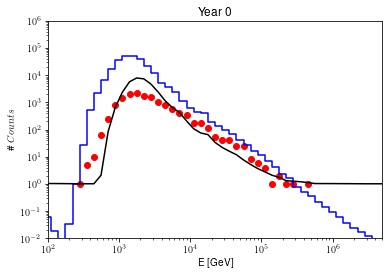

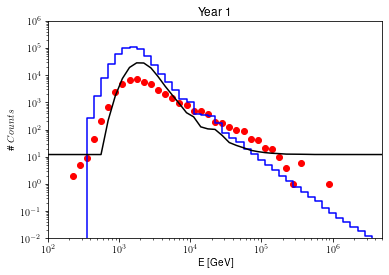

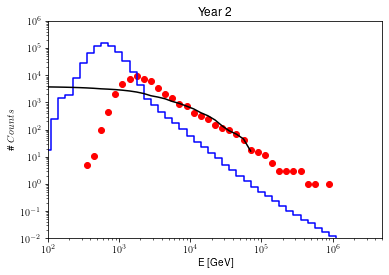

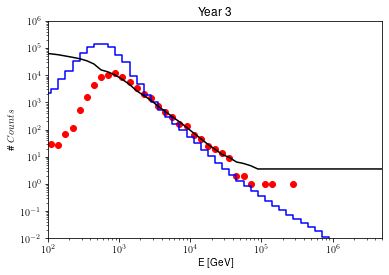

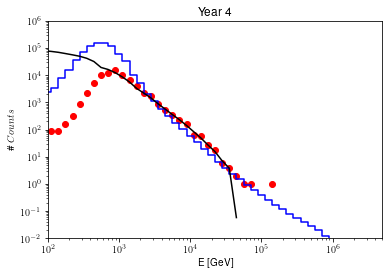

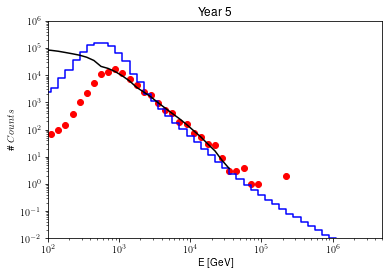

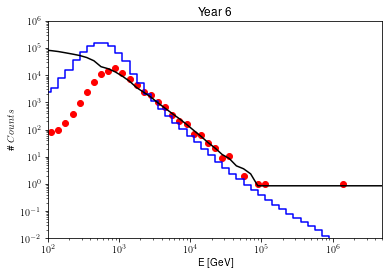

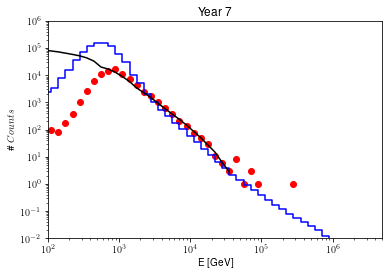

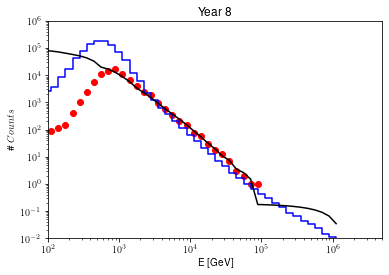

In [88]:
for i in range(0, 9):
    plt.figure()
    plt.title('Year %d ' % (i))
    plt.step(e_grid, projection_ice['numu'][i], color='b' )
    plt.plot(e_grid, new_phi[i], color='k')
    #plt.plot(e_grid, phi_fun[i], color='g')
    #plt.step(e_grid, projection_pone['numu'][i], color='k' )
    plt.scatter(e_grid[:-1], ice_data_dic[i], color='r')
    #plt.plot(e_grid[32:50], ice_data_dic[i][32:50], color='g')
    plt.xscale('log')
    plt.yscale('log')
    plt.ylim(1e-2,1e6)
    plt.xlim(1e2,5e6)
    plt.xlabel(r'E [GeV] ')
    plt.ylabel(r'\# $Counts$')
    plt.savefig("../pics/IceCube_counts_%d.png" % (i), facecolor="white")



In [ ]:
spl_phi = UnivariateSpline(e_grid, projection_ice['numu'][i], k=1, s=1) # The projection_ice / ice_dneeds to be changed to total sum ...... 
def fit_phi(E, A, E_0, b):
          return np.log10(spl_phi(E + E_0 )*A + b)
t_para, _p = optimize.curve_fit(fit_phi, e_grid[40:67], ice_d))

[197058.18526097 120431.41681509 102069.60654794  80673.73361973
  65156.15253778  62036.08842647  58861.97239924  51195.31332686
  34128.088906    18481.45362454]
[ 32285  64262  81383 102203  76060  57440  43559  28882  23446  13140]


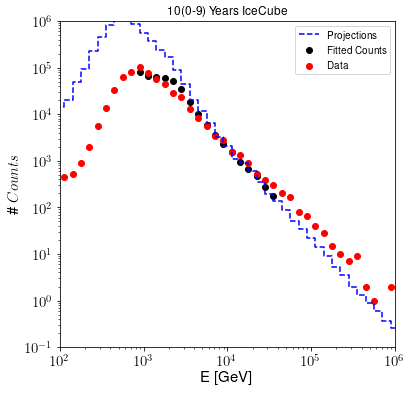

In [100]:
plt.figure(figsize=(std_size,std_size))
plt.title(r"10(0-9) Years IceCube")
plt.step(e_grid, np.sum(projection_ice['numu'], axis=0), "--", color='b', label=r"Projections" )
plt.scatter(e_grid[40:], np.sum(np.array(phi_fit)[0:, 40:], axis=0), color='k', label="Fitted Counts" )
plt.scatter(e_grid[:-1], ice_d, color='r', label="Data")
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.ylim(1e-1,1e6)
plt.xlim(100,1e6)
plt.xlabel(r'E [GeV] ', fontsize=fontsize)
plt.ylabel(r'\# $Counts$', fontsize=fontsize)
plt.legend()
plt.savefig("")
print(np.sum(np.array(phi_fit),axis=0)[37:47])
print((ice_d[37:47]))

In [98]:
np.sum(np.array(phi_fit)[0:, 40:], axis=0)

array([80673.73361973, 65156.15253778, 62036.08842647, 58861.97239924,
       51195.31332686, 34128.088906  , 18481.45362454,  9935.53838885,
        5809.63495733,  3660.08315591,  2237.96119186,  1504.4488869 ,
         936.08956258,   675.03765666,   468.9336571 ,   277.20278215,
         175.82610712,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
      

In [90]:
tmp_ice_counter = 0
tmp_pro_counter = 0
for y in range(3,9):
    tmp_ice_counter += np.sum(ice_data_dic[y][40:])
    tmp_pro_counter += np.sum(np.nan_to_num(phi_fit[y][40:]))
    print("Year = %d, Data sum = %.5e, Projection sum = %.5e" % (y+1, np.sum(ice_data_dic[y][40:]),
           np.sum(np.nan_to_num(phi_fit[y][40:]))))
print('Ice Counter =  %.5e, pro counter = %.5e ' %(tmp_ice_counter, tmp_pro_counter))

Year = 4, Data sum = 3.51160e+04, Projection sum = 2.97062e+04
Year = 5, Data sum = 4.36570e+04, Projection sum = 3.61379e+04
Year = 6, Data sum = 4.71450e+04, Projection sum = 3.94936e+04
Year = 7, Data sum = 4.86290e+04, Projection sum = 3.86937e+04
Year = 8, Data sum = 4.70100e+04, Projection sum = 3.74526e+04
Year = 9, Data sum = 4.56510e+04, Projection sum = 3.73898e+04
Ice Counter =  2.67208e+05, pro counter = 2.18874e+05 


This is the Poissonian CL

In [91]:
tmp_pois = []
for i in range(0,9):
    tmp_pois.append(np.nan_to_num(np.abs(np.array(ice_data_dic[i][40:80] - phi_fit[i][40:80])) / np.nan_to_num(np.array(phi_fit[i][40:80]))**(1/2) ))

In [92]:
tmp_pois

[array([ 5.01769285, 19.10203235, 49.29518922, 64.41378694, 65.60943012,
        45.15259081, 28.0854562 ,  9.6474186 ,  3.1165974 ,  0.34910183,
         9.74606268,  7.04257935, 11.49594012,  6.07831435,  3.27608558,
         4.40545136,  6.21668309,  3.48339072,  5.89508477,  1.22091643,
         1.2093838 ,  0.71888119,  0.75924477,  0.18682189,  0.27835484,
         0.23940716,  1.09984852,  0.12583056,  1.01918212,  1.0183219 ,
         1.01737044,  1.01617134,  1.01465976,  1.01325324,  1.01148021,
         1.00924367,  1.00923973,  1.00923606,  1.00923143,  1.0092256 ]),
 array([ 18.26084933,  32.97774085,  93.12402574, 127.22975415,
        134.91230085, 100.43878637,  63.5050477 ,  30.29325151,
          8.58153123,   1.37631873,  20.23675785,  11.44523961,
         31.14661147,  26.87841172,   9.59674896,  14.73576876,
         15.2753607 ,  13.01224155,  13.89919199,   6.61162677,
          6.45645638,   2.03827921,   1.48727005,   0.85785985,
          2.41833664,   3.2538

This is the chi2 CL


In [93]:
CL_data_b = {}
tmp_cl = {}
for y in range(0,9):
  tmp_=np.sum(np.nan_to_num(np.abs(np.array(ice_data_dic[y][48:70] - phi_fit[y][48:70])) / np.nan_to_num(np.array(phi_fit[y][48:70]))**(1/2) ))
  tmp_cl[y] =chi2.sf(tmp_**2, 2)
  k = np.nan_to_num(np.sum(np.nan_to_num((ice_data_dic[y][48:])**2 / 
                                         np.nan_to_num(phi_fit[y])[48:-1])))            
  print(k)
  CL_data_b[y] = chi2.sf(k, 2)
# np.nan_to_num(np.sum(np.nan_to_num((ice_data_dic[y][38:] - np.nan_to_num(phi_fit[y])[38:-1])**2 / np.nan_to_num(phi_fit[y])[38:-1]))

2843.989032388055
10156.892963197648
1.7976931348623157e+308
735.2928277660321
1.7976931348623157e+308
1.7976931348623157e+308
839.6915546567435
1.7976931348623157e+308
871.1716117458743


/tmp/ipykernel_5037/2191365942.py:6: RuntimeWarning: divide by zero encountered in true_divide
  k = np.nan_to_num(np.sum(np.nan_to_num((ice_data_dic[y][48:])**2 /
/tmp/ipykernel_5037/2191365942.py:6: RuntimeWarning: invalid value encountered in true_divide
  k = np.nan_to_num(np.sum(np.nan_to_num((ice_data_dic[y][48:])**2 /
/home/kruteesh/miniconda3/envs/pdm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [94]:
chi2.sf(53973.1535298152, 2)

0.0

In [95]:
CL_data_b

{0: 0.0,
 1: 0.0,
 2: 0.0,
 3: 2.1537295118424817e-160,
 4: 0.0,
 5: 0.0,
 6: 4.605700104536892e-183,
 7: 0.0,
 8: 6.721839121802549e-190}

In [96]:
CL_data_b, np.sum(np.nan_to_num((ice_d - np.sum(phi_fit, axis=0)[:-1])**2 / np.sum(phi_fit, axis=0)[:-1]))

({0: 0.0,
  1: 0.0,
  2: 0.0,
  3: 2.1537295118424817e-160,
  4: 0.0,
  5: 0.0,
  6: 4.605700104536892e-183,
  7: 0.0,
  8: 6.721839121802549e-190},
 20142040.86893709)